In [42]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
urls = {
    "Polymarket" : 'https://clob.polymarket.com/prices-history?market=58189491556125666756381190843159859466918849062932749642733305810000646541219&interval=max',
    "Kalshi" : 'https://api.elections.kalshi.com/trade-api/v2/series/KXETHATH/markets/KXETHATH-25DEC31/candlesticks?period_interval=1440&start_ts=1759640650&end_ts=1762319050',
    "ETH_Price" : 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days=31'
}

In [43]:
def load_polymarket_data(url, name):
    r = requests.get(url)
    data = r.json()["history"]
    df = pd.DataFrame(data)
    df["date"] = pd.to_datetime(df["t"], unit="s").dt.date
    df = df.groupby("date")["p"].mean().reset_index()
    df = df.rename(columns={"p": name})
    return df

def load_coingecko_data(url, name):
    r = requests.get(url)
    data = r.json()["prices"]
    df = pd.DataFrame(data, columns=["timestamp", "price"])
    df["date"] = pd.to_datetime(df["timestamp"], unit="ms").dt.date
    df = df.groupby("date")["price"].mean().reset_index()
    df = df.rename(columns={"price": name})
    return df

def load_kalshi_data(url, name):
    r = requests.get(url)
    candlesticks = r.json()["candlesticks"]
    
    # Extract timestamp and close price, filtering out None values
    data = [[candle["end_period_ts"], float(candle["price"]["close_dollars"])] 
            for candle in candlesticks
            if candle["price"]["close_dollars"] is not None]
    
    df = pd.DataFrame(data, columns=["timestamp", "price"])
    df["date"] = pd.to_datetime(df["timestamp"], unit="s").dt.date
    df = df.groupby("date")["price"].mean().reset_index()
    df = df.rename(columns={"price": name})
    return df

In [44]:
df_dict = {
    "Polymarket": load_polymarket_data(urls["Polymarket"], "Polymarket"),
    "ETH_Price": load_coingecko_data(urls["ETH_Price"], "ETH_Price"),
    "Kalshi": load_kalshi_data(urls["Kalshi"], "Kalshi")
}

df_merged = df_dict["ETH_Price"]
for name, df in df_dict.items():
    if name != "ETH_Price":
        df_merged = pd.merge(df_merged, df, on="date", how="outer")
df_merged = df_merged.sort_values("date").reset_index(drop=True)
df_merged.head()

,date,ETH_Price,Polymarket,Kalshi
0,2025-10-05,4534.243539,0.715309,NaN
1,2025-10-06,4602.295399,0.757882,0.68
2,2025-10-07,4623.289376,0.785312,0.80
3,2025-10-08,4482.760618,0.714132,0.66
4,2025-10-09,4387.830870,0.665278,0.73


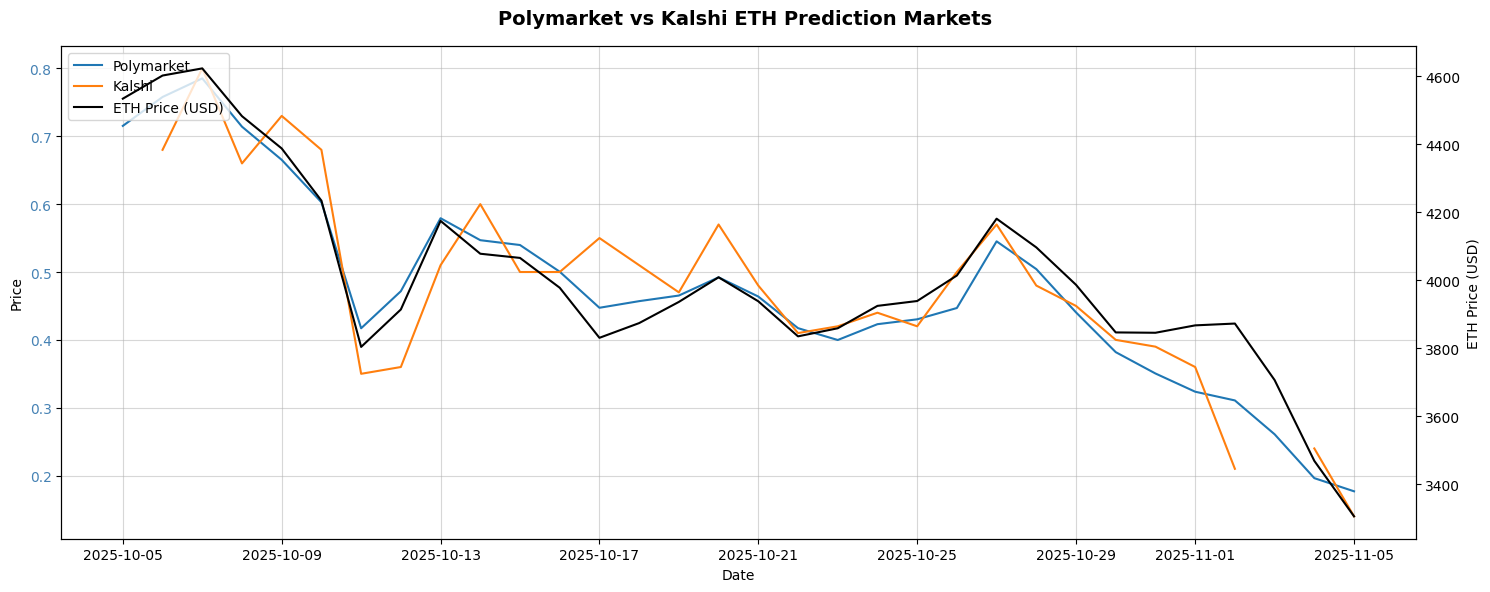

In [45]:
cols = ["Polymarket", "Kalshi"]
fig, ax1 = plt.subplots(figsize=(15, 6))
for col in cols:
    ax1.plot(df_merged["date"], df_merged[col], label=col)
ax1.set_xlabel("Date")
ax1.set_ylabel("Price")
ax1.tick_params(axis="y", labelcolor="steelblue")

ax2 = ax1.twinx()
ax2.plot(df_merged["date"], df_merged["ETH_Price"], color="black", label="ETH Price (USD)")
ax2.set_ylabel("ETH Price (USD)", color="black")
ax2.tick_params(axis="y", labelcolor="black")

fig.suptitle("Polymarket vs Kalshi ETH Prediction Markets", fontsize=14, fontweight="bold")
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")
ax1.grid(which='major', axis='both', alpha=0.5)
ax1.set_axisbelow(True) 

plt.tight_layout()
plt.show()

In [46]:
corr = df_merged.select_dtypes(include=['float', 'int']).corr()
corr

,ETH_Price,Polymarket,Kalshi
ETH_Price,1.000000,0.966469,0.890372
Polymarket,0.966469,1.000000,0.929966
Kalshi,0.890372,0.929966,1.000000


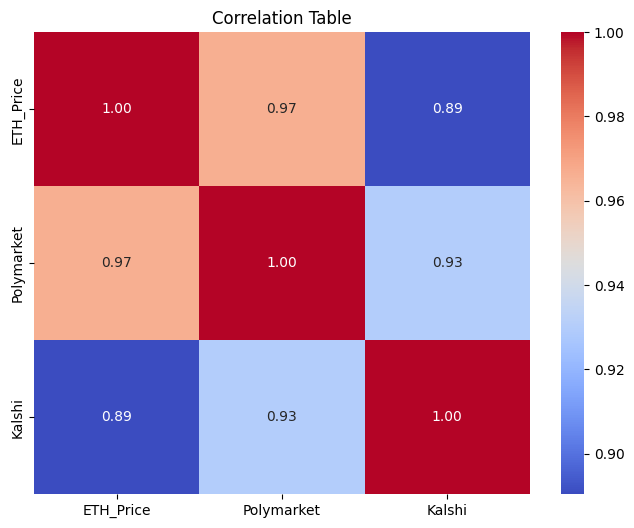

In [47]:
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Table")
plt.show()

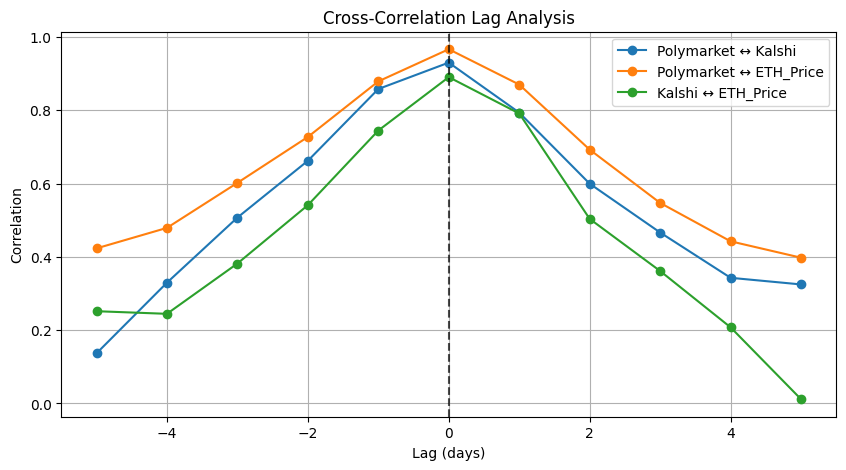

In [56]:
def multi_cross_correlation(df, pairs, max_lag):
    plt.figure(figsize=(10, 5))
    lags = range(-max_lag, max_lag + 1)
    for col1, col2 in pairs:
        df_clean = df[[col1, col2]].dropna()
        correlations = [df_clean[col1].corr(df_clean[col2].shift(lag)) for lag in lags]
        plt.plot(lags, correlations, marker='o', label=f"{col1} ↔ {col2}")
    
    plt.axvline(0, color='black', linestyle='--', alpha=0.7)
    plt.title("Cross-Correlation Lag Analysis")
    plt.xlabel("Lag (days)")
    plt.ylabel("Correlation")
    plt.legend()
    plt.grid(True)
    plt.show()
    
pairs = [
    ("Polymarket", "Kalshi"),
    ("Polymarket", "ETH_Price"),
    ("Kalshi", "ETH_Price")
]

multi_cross_correlation(df_merged, pairs, max_lag=5)
